
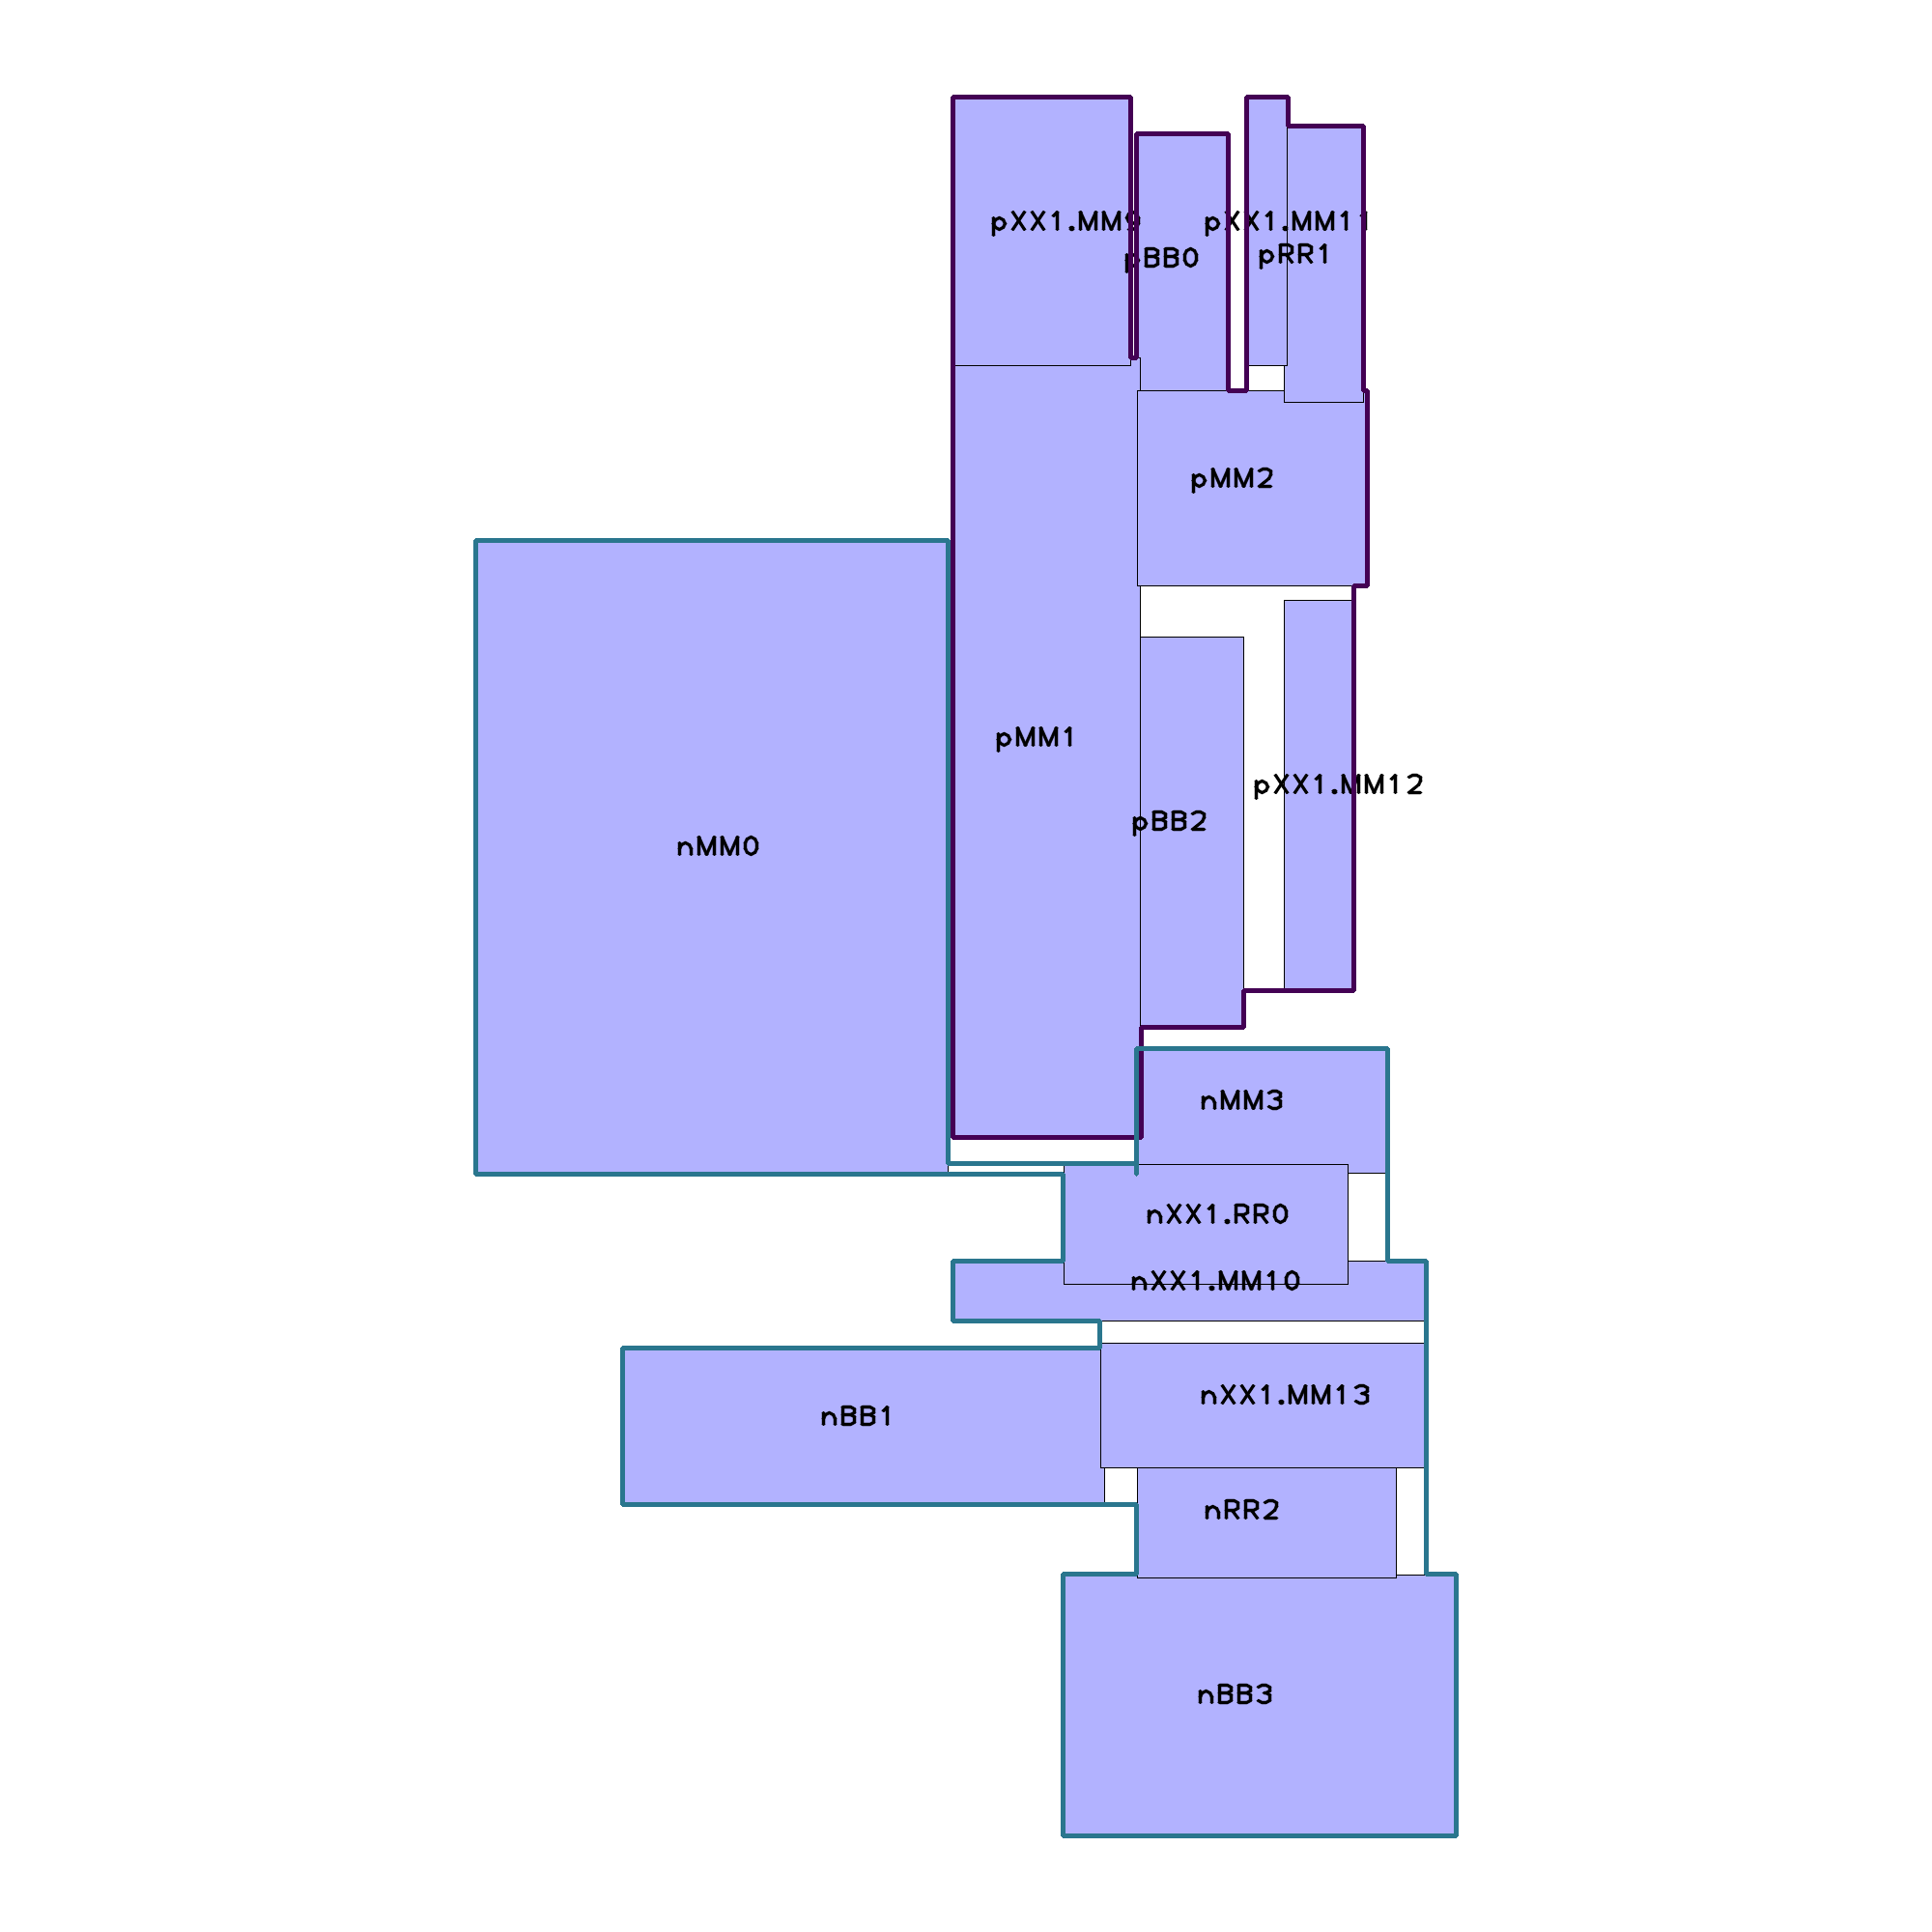


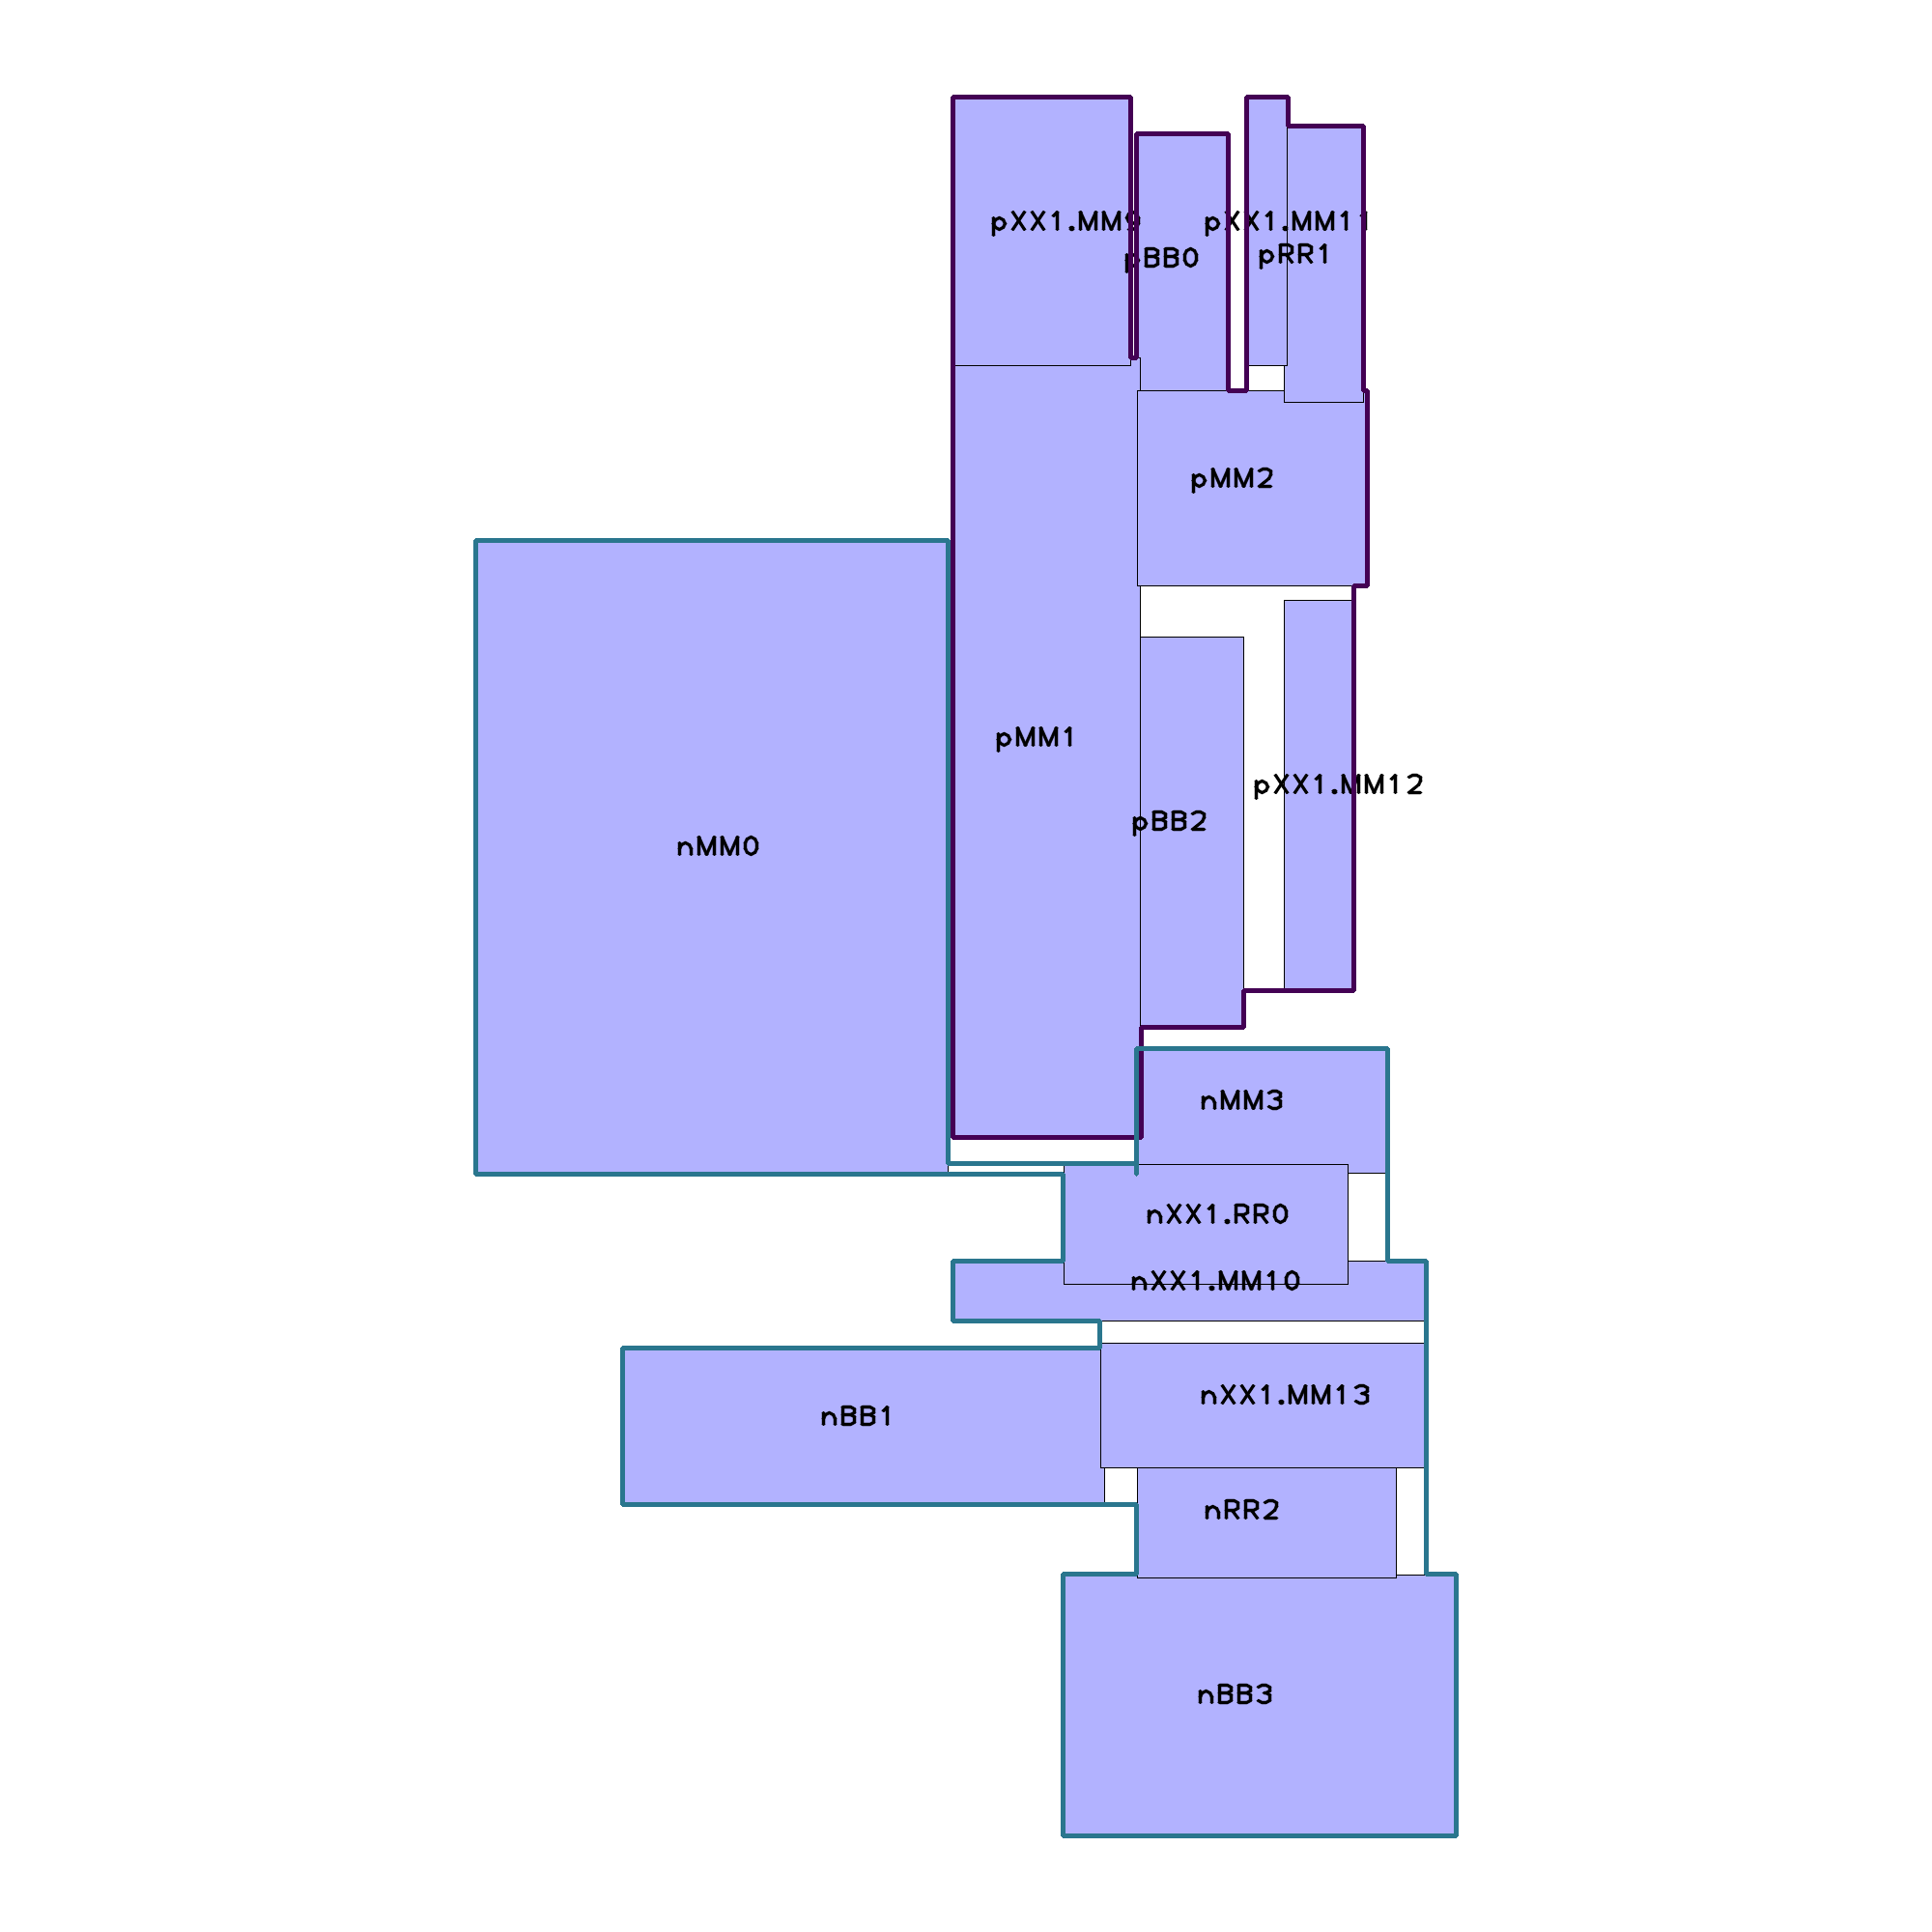

In [3]:

import ipyplot
from functools import reduce
import numpy as np
import cv2 as cv
from PIL import ImageColor
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString
from pathlib import Path


def get_contour(points, min_length, filter=None):
    # print("-------------------------------")
    from shapely.geometry import LineString, MultiLineString
    elements = np.array(points)
    orders = np.lexsort((elements[:, 0, [1, 0]]).T)
    elements_left_top_order = elements[orders]
    contour = []
    align_contour = LineString()
    total_length = elements_left_top_order[..., 1, 1].max(
    ) - elements_left_top_order[..., 0, 1].min()

    for order, element in zip(orders, elements_left_top_order):
        edge = LineString(((0, element[0][1]), (0, element[1][1])))
        if filter and not filter(element):
            continue

        line_diff = edge.difference(align_contour)
        if line_diff.length < min_length:
            continue

        edge_x = element[0][0]
        if not line_diff.is_empty:
            if isinstance(line_diff, LineString):
                contour.append(LineString(
                    ((edge_x, line_diff.coords[0][1]), (edge_x, line_diff.coords[1][1]))))
            elif isinstance(line_diff, MultiLineString):
                for line in line_diff.geoms:
                    contour.append(LineString(
                        ((edge_x, line.coords[0][1]), (edge_x, line.coords[1][1]))))
            else:
                raise TypeError(
                    "line_diff is not LineString or MultiLineString")

        align_contour = align_contour.union(line_diff)
        if align_contour.length >= total_length:
            break

    contour.sort(key=lambda x: x.coords[0][1])
    contour = [[c.coords[0], c.coords[1]]for c in contour]
    contour = np.array(contour)
    contour_top = []
    contour_down = []
    for i in range(len(contour)-1):
        edge_end = contour[i][1]
        next_edge_start = contour[i+1][0]
        if edge_end[1] != next_edge_start[1]:
            if next_edge_start[0] > edge_end[0]:
                next_edge_start[1] = edge_end[1]
            else:
                edge_end[1] = next_edge_start[1]
        if edge_end[0] > next_edge_start[0]:
            contour_down.append((edge_end, next_edge_start))
        elif edge_end[0] < next_edge_start[0]:
            contour_top.append((edge_end, next_edge_start))

    contour_top = np.array(contour_top)
    contour_down = np.array(contour_down)

    return contour, contour_top, contour_down


def generate_guard_ring(points, min_length, margin):
    # points = np.asarray(points).reshape((-1, 4, 2))
    points = points.copy()
    points[..., [0, 1], 0] -= margin
    points[..., [2, 3], 0] += margin
    points[..., [1, 2], 1] += margin
    points[..., [0, 3], 1] -= margin

    left_edges = points[:, [0, 1]]
    top_edges = points[:, [1, 2]]
    right_edges = points[:, [3, 2]]
    bottom_edges = points[:, [0, 3]]

    def switch(x): return np.flip(x, axis=-1)
    def reflect_y(x): return x*np.array([-1, 1])

    def apply_transformation(x, transformation):
        return [reduce(lambda x, f: f(x), transformation, r) if r.size else r for r in x]

    # get left contour
    left,  left_top, left_down = get_contour(
        left_edges, min_length, None)
    top_edges = np.stack((*top_edges, *left_down))
    # exit()
    left_start_x = left[0, 0, 0]
    left_end_x = left[-1, 1, 0]

    # get top contour
    transformation = [switch, reflect_y]
    top_edges = apply_transformation([top_edges], transformation)[0]
    top, top_right, top_left = apply_transformation(
        get_contour(top_edges, min_length, lambda x: x[0, 1] >= left_end_x), transformation[::-1])
    top_end_x = top[-1, 1, 1]

    # get right contour
    transformation = [reflect_y]
    right_edges = apply_transformation([right_edges], transformation)[0]
    right, right_top, right_down = apply_transformation(
        get_contour(right_edges, min_length, lambda x: x[1, 1] <= top_end_x), transformation[::-1])

    right_start_x = right[0, 0, 0]

    # get bottom contour
    transformation = [switch]
    bottom_edges = apply_transformation([bottom_edges], transformation)[0]
    bottom, bottom_right, bottom_left = apply_transformation(
        get_contour(bottom_edges, min_length, lambda x: x[0, 1] >= left_start_x and x[1, 1] <= right_start_x), transformation[::-1])

    final_contour = np.concatenate(
        ([x for x in (
            left, left_top, left_down,
            top, top_right, top_left,
            right, right_top, right_down,
            bottom, bottom_right, bottom_left
        ) if x.size > 0]), axis=0)

    return final_contour


def draw_contour(block_names, points, contours):
    # contours
    # [array([[[ 6.  ,  6.  ],
    #          [ 6.  , 12.  ]],
    contour = np.concatenate(contours)
    point_set = np.vstack(
        (points.reshape((-1, 2)), contour.reshape((-1, 2))))
    left_bottom = point_set.min(axis=0)
    right_top = point_set.max(axis=0)

    difference = right_top - left_bottom
    max_width, min_width = max(difference), min(difference)

    deltax, deltay = 0, (max_width-min_width) / 2
    if difference[1] > difference[0]:
        deltax, deltay = deltay, deltax

    points += np.array([-left_bottom[0] + deltax, -left_bottom[1] + deltay])
    contour += np.array([-left_bottom[0] + deltax, -left_bottom[1] + deltay])

    width = 2000
    size = width*0.9
    ratio = size/max_width
    points *= ratio
    contour *= ratio

    img = np.ones((width, width, 3), np.uint8)*255

    delta = (width-size) / 2
    points += delta
    points[..., 1] = width - points[..., 1]
    contour += (width-size) / 2
    contour[..., 1] = width - contour[..., 1]

    # draw rectangle and label
    for block_name, point in zip(block_names, points):
        point = point.astype(int)
        cv.rectangle(img, point[0], point[2], ImageColor.getrgb("#B2B2FF"), -1)
        cv.rectangle(img, point[0], point[2], 0, 1)
    for block_name, point in zip(block_names, points):
        point = point.astype(int)
        cv.putText(img, block_name, np.array([np.mean(point, axis=0)[0]*.95, np.mean(point, axis=0)[1]]).astype(int),
                   cv.FONT_HERSHEY_PLAIN, 2, color=(0, 0, 0), thickness=2, lineType=cv.LINE_AA)

    ctr = 0
    for i, _ in enumerate(contours):
        color = (np.array((plt.get_cmap("viridis")(
            i*100)[:3]))*255).astype(int).tolist()
        for _ in range(len(contours[i])):
            edge = contour[ctr].astype(int)
            cv.line(img, edge[0],
                    edge[1], color, 3)
            ctr += 1
    # img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img


# def draw_square(block_names, points):
#     point_set = points.reshape((-1, 2))
#     left_bottom = point_set.min(axis=0)
#     right_top = point_set.max(axis=0)

#     difference = right_top - left_bottom
#     max_width, min_width = max(difference), min(difference)

#     deltax, deltay = 0, (max_width-min_width) / 2
#     if difference[1] > difference[0]:
#         deltax, deltay = deltay, deltax

#     points += np.array([-left_bottom[0] + deltax, -left_bottom[1] + deltay])

#     width = 2000
#     size = width*0.9
#     ratio = size/max_width
#     points *= ratio

#     img = np.ones((width, width, 3), np.uint8)*255

#     delta = (width-size) / 2
#     points += delta
#     points[..., 1] = width - points[..., 1]

#     # draw rectangle and label
#     for block_name, point in zip(block_names, points):
#         point = point.astype(int)
#         cv.rectangle(img, point[0], point[2], ImageColor.getrgb("#B2B2FF"), -1)
#         cv.rectangle(img, point[0], point[2], 0, 1)
#     for block_name, point in zip(block_names, points):
#         point = point.astype(int)
#         cv.putText(img, block_name, np.array([np.mean(point, axis=0)[0]*.95, np.mean(point, axis=0)[1]]).astype(int),
#                    cv.FONT_HERSHEY_PLAIN, 2, color=(0, 0, 0), thickness=2, lineType=cv.LINE_AA)

#     # img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
#     return img

def read_from_list(points):
    # 單一block需要guard ring
    single_point = [(8, 23), (8, 28.3), (14.809999999999999, 28.3),
                    (14.809999999999999, 23)]
    block_names = [str(i) for i in range(16)]
    points = np.array(points).reshape((-1, 4, 2))
    single_point = np.array(single_point).reshape((-1, 4, 2))
    contour = generate_guard_ring(points, 3, 1)
    contour2 = generate_guard_ring(single_point, 3, 1)
    img = draw_contour(block_names, points, [contour, contour2])
    return img


def read_from_excel(path):
    block_names = []
    points = []
    with open(path) as f:
        for d in f.readlines()[:-1]:
            d = d.split()
            x, y, width, height = np.array(d[1:5], dtype=float)
            block_names.append(d[0])
            points.append(
                [(x, y), (x, y+height), (x+width, y+height), (x+width, y)])

    points1 = [points[i]
               for i, v in enumerate(block_names) if v.startswith("p")]
    points2 = [points[i]
               for i, v in enumerate(block_names) if v.startswith("n")]
    points1 = np.array(points1).reshape((-1, 4, 2))
    points2 = np.array(points2).reshape((-1, 4, 2))
    contour = generate_guard_ring(points1, 0, margin=0.01)
    contour2 = generate_guard_ring(points2, 0, margin=0.01)
    points = np.array(points).reshape((-1, 4, 2))
    img = draw_contour(block_names, points, [contour, contour2])
    return img


# 示例使用 left bottom/left top/right top/right bottom
points = [(8, 23), (8, 28.3), (14.809999999999999, 28.3), (14.809999999999999, 23),
          (5, 28), (5, 35.3), (17.85, 35.3), (17.85, 28),
          (8, 36), (8, 43.05), (15.75, 43.05), (15.75, 36),
          (8, 16), (8, 23.3), (15.25, 23.3), (15.25, 16),
          (18, 26), (18, 36.6), (24.81, 36.6), (24.81, 26),
          (4, 21), (4, 28.3), (8.01, 28.3), (8.01, 21),
          (15, 16), (15, 26.6), (25.68, 26.6), (25.68, 16),
          (25, 29), (25, 50.2), (37.85, 50.2), (37.85, 29),
          (26, 21), (26, 28.3), (39.12, 28.3), (39.12, 21),
          (7, 7), (7, 14.95), (15.85, 14.95), (15.85, 7),
          (38, 29), (38, 50.2), (50.85, 50.2), (50.85, 29),
          (5, 43), (5, 50.3), (17.85, 50.3), (17.85, 43),
          (18, 37), (18, 47.6), (24.81, 47.6), (24.81, 37),
          (0, 13), (0, 20.5), (7.05, 20.5), (7.05, 13),
          (16, 8), (16, 15.5), (23.05, 15.5), (23.05, 8),
          (26, 16), (26, 21.3), (32.81, 21.3), (32.81, 16)
          ]
# img = read_from_list(points)
# cv.imwrite("test.png", img)
# ipyplot.plot_images([img], img_width=500)

# if (path := Path("Bandgap-2900-529-2024-01-19-01-47-52.pl")).exists():
#     img = read_from_excel(path)
#     ipyplot.plot_images([img], img_width=500)
if (path := Path("Bandgap-3000-526-2024-01-19-01-48-59.pl")).exists():
    img = read_from_excel(path)
    ipyplot.plot_images([img], img_width=500)